![](https://i.ibb.co/G0sLBVs/30-Days-ML-Hero.png). 


Machine learning beginner → Kaggle competitor in 30 days. Non-coders welcome.



The dataset is used for this competition is synthetic, but based on a real dataset. The original dataset deals with predicting the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

# Loading data

In [2]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
! kaggle competitions download -c 30-days-of-ml -p /content/drive/My\Drive/kaggle/30_ML

  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 68.7MB/s]
 44% 11.0M/25.2M [00:00<00:00, 114MB/s]
100% 25.2M/25.2M [00:00<00:00, 121MB/s]
 60% 24.0M/40.3M [00:00<00:00, 88.2MB/s]
100% 40.3M/40.3M [00:00<00:00, 134MB/s] 


In [4]:
%%capture
!pip install catboost

In [5]:
%%capture
!pip install category_encoders

In [6]:
%%capture
!pip install -U keras-tuner

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from tensorflow.keras.optimizers import Adam

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
import warnings
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder


from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from category_encoders import MEstimateEncoder

from sklearn.ensemble import VotingRegressor
from scipy.stats import reciprocal, uniform

from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor


warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/train.csv.zip')
test = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/test.csv.zip')

In [9]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [10]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [11]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [12]:
X_test = test.drop(['id'], axis=1)

# Ensemble

In [13]:
features, target = split_data(train, 'target')


In [13]:
features.shape

(300000, 25)

In [14]:
cat_feature = list(features.select_dtypes(include=['object']))
cat_feature 

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

In [15]:
encoder = LabelEncoder()

In [16]:
for cat in cat_feature:
    encoder = LabelEncoder()
    encoder.fit(list(features[cat].values)) 
    features[cat] = encoder.transform(list(features[cat].values))


In [17]:
features.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,1,2,1,1,0,4,2,13,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,2,1,1,0,0,1,3,0,5,0,14,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,3,0,0,0,2,1,3,0,3,0,5,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,4,1,1,0,2,1,3,0,4,2,10,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,6,0,0,0,2,1,3,0,4,0,13,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [18]:
features = features.drop('id', axis=1)

In [19]:
test_id = test ['id']

In [20]:
X_test = test.copy()
for cat in cat_feature:
    X_test[cat] = encoder.transform(list(X_test[cat].values))


X_test_cv = X_test.drop(['id'], axis=1)

In [21]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


#Keras


In [22]:
features.shape, X_test_cv.shape

((300000, 24), (200000, 24))

In [23]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [24]:
X_train_XGB.shape

(225000, 24)

In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])    
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=512,    
                                   max_value=4096,   
                                   step=32),
                    input_dim=24,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=128,   
                                   max_value=600,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=80,                
    directory='test_directory'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4096, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 600, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=20,                 
             validation_split=0.2,     
             )

Trial 80 Complete [00h 01m 22s]
mae: 0.5901838541030884

Best mae So Far: 0.5868509411811829
Total elapsed time: 01h 10m 46s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 576)               14400     
_________________________________________________________________
dense_1 (Dense)              (None, 192)               110784    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 193       
Total params: 125,377
Trainable params: 125,377
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 4s 2ms/step - loss: 0.5866 - mae: 0.5866

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1248)              31200     
_________________________________________________________________
dense_1 (

In [ ]:
UNITS = 576
UNITS_HIDDEN = 192
ACTIVATION = 'tanh'



BATCH_SIZE_PER_REPLICA = 256

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dense(UNITS_HIDDEN, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5824


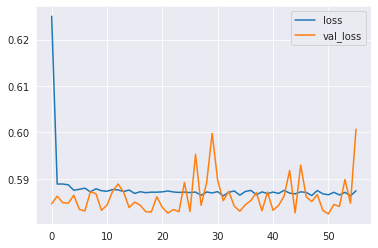

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7399807801764727


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras.csv',index=False)
from google.colab import files
files.download("my_submission_keras.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.010722
1,5,8.218580
2,15,8.283298
3,16,8.125624
4,17,8.140952


#Keras 2

In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])    
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=64,    
                                   max_value=1024,   
                                   step=32),
                    input_dim=24,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=256,   
                                   step=32),
                    activation=activation_choice))  
    model.add(Dropout(0.3))   
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=256,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=42,                
    directory='test_directory_2'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=20,                 
             validation_split=0.2,     
             )

Trial 42 Complete [00h 00m 41s]
mae: 0.5903564095497131

Best mae So Far: 0.586026668548584
Total elapsed time: 00h 38m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=3)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 960)               24000     
_________________________________________________________________
dense_1 (Dense)              (None, 192)               184512    
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 193       
Total params: 245,761
Trainable params: 245,761
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 4s 2ms/step - loss: 0.6233 - mae: 0.6233

Model: "sequential"
_________

In [ ]:
UNITS = 128
UNITS_HIDDEN_1 = 192

UNITS_HIDDEN_2 = 192
ACTIVATION = 'relu'

BATCH_SIZE_PER_REPLICA = 256

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dropout(rate=0.3),
    layers.Dense(UNITS_HIDDEN_2, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5825


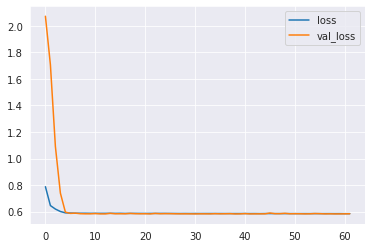

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7381312326719619


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_3lay.csv',index=False)
from google.colab import files
files.download("my_submission_keras_3lay.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.032942
1,5,8.287011
2,15,8.326889
3,16,8.106340
4,17,8.170339


#Keras 3 (reBoot)

In [25]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])    
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=32,    
                                   max_value=512,   
                                   step=32),
                    input_dim=24,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=32,   
                                   max_value=512,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [27]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=42,                
    directory='test_directory_8'     
    )

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [30]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=30,                 
             validation_split=0.2,     
             )

Trial 43 Complete [00h 02m 22s]
mae: 0.586673378944397

Best mae So Far: 0.5848336815834045
Total elapsed time: 01h 22m 20s
INFO:tensorflow:Oracle triggered exit


In [31]:
models = tuner.get_best_models(num_models=2)

In [32]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 6s 2ms/step - loss: 0.5825 - mae: 0.5825

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               8000      
_________________________________________________________________
dense_1 (Dens

In [33]:
UNITS = 64
UNITS_HIDDEN = 32
ACTIVATION = 'relu'
optimizer = Adam(lr=0.035) 


BATCH_SIZE_PER_REPLICA = 256

In [34]:
early_stopping = EarlyStopping(
    mode='min', 
    patience=200, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dense(UNITS_HIDDEN, ACTIVATION),
    layers.Dense(1)

])

In [35]:
model.compile(
    optimizer=optimizer, 
    loss='mae'
)

Minimum Validation Loss: 0.5823


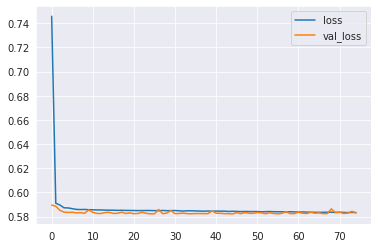

In [36]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=10000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [37]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7369633747728616


In [38]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [39]:
preds = model.predict(X_test_cv)

In [40]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_adam.csv',index=False)
from google.colab import files
files.download("my_submission_keras_adam.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
sub.head()

,Id,target
0,0,8.027167
1,5,8.287356
2,15,8.339341
3,16,8.072139
4,17,8.193595


#Keras 4

In [48]:
def build_model(hp):
    model = Sequential()
       
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=64,    
                                   max_value=512,   
                                   step=32),
                    input_dim=24, 
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=512,   
                                   step=32),
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(1)) 
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [57]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=10,                
    directory='test_directory_7'     
    )

In [58]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [59]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=512,           
             epochs=20,                 
             validation_split=0.2,     
             )

Trial 10 Complete [00h 00m 48s]
mae: 0.5911945104598999

Best mae So Far: 0.5876796841621399
Total elapsed time: 00h 10m 21s
INFO:tensorflow:Oracle triggered exit


In [60]:
models = tuner.get_best_models(num_models=2)

In [61]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               4800      
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 192)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 352)               67936     
_________________________________________________________________
dropout_1 (Dropout)          (None, 352)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 352)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [62]:
UNITS = 288
UNITS_HIDDEN_1 = 352
ACTIVATION = 'relu'
BATCH_SIZE_PER_REPLICA = 512

In [63]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)

])

In [64]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5830


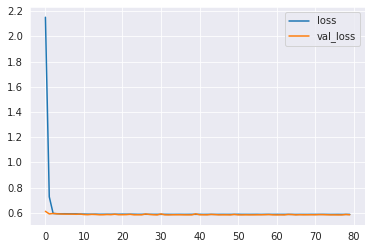

In [65]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [66]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7388541738165599


In [67]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [68]:
preds = model.predict(X_test_cv)

In [69]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_4.csv',index=False)
from google.colab import files
files.download("my_submission_keras_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
sub.head()

,Id,target
0,0,8.043885
1,5,8.237064
2,15,8.298949
3,16,8.102369
4,17,8.143108


#LGMB/XGB


In [22]:
#LGMB

params_lgb = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.003899,
    'num_boost_round': 100000,
    "num_leaves": 62,
    "max_depth": 95,
    "feature_fraction": 0.2256,
    "bagging_fraction": 0.8805,
    "min_child_samples": 290,
    "reg_alpha": 9.562925,
    "reg_lambda": 9.35581,
    "max_bin": 881,
    "min_data_per_group": 125,
    "bagging_freq": 1,
    "cat_smooth": 96,
    "cat_l2": 19,
    "verbosity": -1,
    "bagging_seed": 42,
    "feature_fraction_seed": 42,
    "seed": 42,
    'random_state':42
}


#XGBboost

xgb_params = {
    'n_estimators': 5000,
    'learning_rate': 0.1235,
    'subsample': 0.95,
    'colsample_bytree': 0.11,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 66.1,
    'reg_alpha': 15.9,
    'random_state':42,
    'verbosity': 0
}


xgb_params_2 = {
    'n_estimators': 5000,
    'learning_rate': 0.247,
    'subsample': 0.95,
    'colsample_bytree': 0.11,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 66.1,
    'reg_alpha': 15.9,
    'random_state':42,
    'verbosity': 0
}


xgb_params_3 = {'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.036283,
    'reg_lambda': 0.0008746,
    'reg_alpha': 23.13181,
    'subsample': 0.787549,
    'colsample_bytree': 0.11807,
    'max_depth':3
    }


### Stacking

In [ ]:
XGB_1 = XGBRegressor(**xgb_params)
XGB_2 = XGBRegressor(**xgb_params_2)
XGB_3 = XGBRegressor(**xgb_params_3)
LGBM = LGBMRegressor(**params_lgb)

In [ ]:
estimators = [XGB_1, XGB_2, LGBM]

In [23]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [ ]:
for estimator in estimators:
    print('Обучение', estimator)
    estimator.fit(X_train_XGB, y_train_XGB)

Обучение XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.11, gamma=0,
             importance_type='gain', learning_rate=0.1235, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=15.9, reg_lambda=66.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=0)
Обучение XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.11, gamma=0,
             importance_type='gain', learning_rate=0.247, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=15.9, reg_lambda=66.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95

In [ ]:
X_val_predictions = np.empty((X_val_XGB.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val_XGB)

In [ ]:
X_val_predictions

array([[8.195625 , 8.164467 , 8.057371 ],
       [8.447451 , 8.398245 , 8.246388 ],
       [8.319532 , 8.307602 , 8.265125 ],
       ...,
       [8.499247 , 8.52269  , 8.911269 ],
       [8.040552 , 7.920083 , 7.7536707],
       [8.469873 , 8.4031925, 8.254602 ]], dtype=float32)

In [ ]:
blender = XGB_1

In [ ]:
blender.fit(X_val_predictions, y_val_XGB)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.11, gamma=0,
             importance_type='gain', learning_rate=0.1235, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=15.9, reg_lambda=66.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=0)

In [ ]:
X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test_cv)

In [ ]:
X_test_predictions

array([[8.11477  , 8.114196 , 8.12039  ],
       [8.45199  , 8.5224285, 8.324602 ],
       [8.433565 , 8.444759 , 8.477477 ],
       ...,
       [8.510586 , 8.595936 , 8.581106 ],
       [8.251127 , 8.238838 , 8.188286 ],
       [8.00691  , 8.006392 , 7.7700253]], dtype=float32)

In [ ]:
stacks = blender.predict(X_test_predictions)

In [ ]:
pd.Series(stacks)

0         8.102695
1         8.451283
2         8.363199
3         8.441261
4         8.155249
            ...   
199995    7.941524
199996    8.432581
199997    8.471201
199998    8.356403
199999    8.041707
Length: 200000, dtype: float32

In [ ]:
Stacking = pd.DataFrame()
Stacking['Id'] = test['id']
Stacking['target'] = stacks


Stacking.to_csv('Stacking.csv', index=False)
files.download('Stacking.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGB Full

In [ ]:
features.shape, X_test_cv.shape

((300000, 24), (200000, 24))

In [ ]:
model = XGBRegressor(**xgb_params)
model.fit(X_train_XGB, y_train_XGB, eval_set = [(X_val_XGB, y_val_XGB)],
          early_stopping_rounds=200, verbose=200)

preds = model.predict(X_test_cv)
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))


[0]	validation_0-rmse:6.82735
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.730233
[400]	validation_0-rmse:0.725708
[600]	validation_0-rmse:0.723184
[800]	validation_0-rmse:0.721784
[1000]	validation_0-rmse:0.720679
[1200]	validation_0-rmse:0.719899
[1400]	validation_0-rmse:0.719098
[1600]	validation_0-rmse:0.718482
[1800]	validation_0-rmse:0.71794
[2000]	validation_0-rmse:0.717557
[2200]	validation_0-rmse:0.71723
[2400]	validation_0-rmse:0.716876
[2600]	validation_0-rmse:0.716574
[2800]	validation_0-rmse:0.71637
[3000]	validation_0-rmse:0.716221
[3200]	validation_0-rmse:0.716056
[3400]	validation_0-rmse:0.715954
[3600]	validation_0-rmse:0.715861
[3800]	validation_0-rmse:0.715852
[4000]	validation_0-rmse:0.715806
[4200]	validation_0-rmse:0.715749
[4400]	validation_0-rmse:0.715708
[4600]	validation_0-rmse:0.71567
[4800]	validation_0-rmse:0.715667
[4999]	validation_0-rmse:0.715623
0.7156304751640391


In [ ]:
sub_XG_full = pd.DataFrame()
sub_XG_full['Id'] = test_id
sub_XG_full['target'] = preds


sub_XG_full.to_csv('XGB_full-ensemble.csv', index=False)
files.download('XGB_full-ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub_XG_full.head()

,Id,target
0,0,8.114770
1,5,8.451990
2,15,8.433565
3,16,8.485857
4,17,8.129815


### XGB Kfolds v2 

In [24]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
mae=[]
idx=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]


# XGBRegressor  v2.0

    model = XGBRegressor(**xgb_params_3)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200, verbose=400)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    mae.append(mean_absolute_error(y_val_g, model.predict(X_val_g)))
    print(idx+1,rmse[idx])
    print(idx+1,mae[idx])
    idx +=1


[15:54:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.50032
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.730936
[800]	validation_0-rmse:0.725057
[1200]	validation_0-rmse:0.722353
[1600]	validation_0-rmse:0.720538
[2000]	validation_0-rmse:0.719247
[2400]	validation_0-rmse:0.718399
[2800]	validation_0-rmse:0.717695
[3200]	validation_0-rmse:0.717176
[3600]	validation_0-rmse:0.716832
[4000]	validation_0-rmse:0.71657
[4400]	validation_0-rmse:0.716325
[4800]	validation_0-rmse:0.716149
[5200]	validation_0-rmse:0.715962
[5600]	validation_0-rmse:0.715833
[6000]	validation_0-rmse:0.715743
[6400]	validation_0-rmse:0.715674
[6800]	validation_0-rmse:0.715632
[7200]	validation_0-rmse:0.715577
[7600]	validation_0-rmse:0.715587
Stopping. Best iteration:
[7484]	validation_0-rmse:0.715571

1 0.7155720006649872
1 0.5686853944724195
[16:08:16] WARNING: /workspace/

In [25]:
sub_XG_v2 = pd.DataFrame()
sub_XG_v2['Id'] = test['id']
sub_XG_v2['target'] = preds

sub_XG_v2.to_csv('XGB_v2.csv', index=False)
files.download('XGB_v2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
sub_XG_v2.head()

,Id,target
0,0,8.083709
1,5,8.397919
2,15,8.418420
3,16,8.506469
4,17,8.129091


### XGB Kfolds v1

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
idx=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]


# XGBRegressor

    model = XGBRegressor(**xgb_params)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200, verbose=200)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    print(idx+1,rmse[idx])
    idx +=1


[0]	validation_0-rmse:6.82899
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.730917
[400]	validation_0-rmse:0.726661
[600]	validation_0-rmse:0.724249
[800]	validation_0-rmse:0.722665
[1000]	validation_0-rmse:0.721542
[1200]	validation_0-rmse:0.720639
[1400]	validation_0-rmse:0.719825
[1600]	validation_0-rmse:0.719194
[1800]	validation_0-rmse:0.718644
[2000]	validation_0-rmse:0.718141
[2200]	validation_0-rmse:0.717751
[2400]	validation_0-rmse:0.71743
[2600]	validation_0-rmse:0.717137
[2800]	validation_0-rmse:0.716849
[3000]	validation_0-rmse:0.716724
[3200]	validation_0-rmse:0.716618
[3400]	validation_0-rmse:0.716467
[3600]	validation_0-rmse:0.716305
[3800]	validation_0-rmse:0.716239
[4000]	validation_0-rmse:0.716188
[4200]	validation_0-rmse:0.716174
[4400]	validation_0-rmse:0.716123
[4600]	validation_0-rmse:0.716072
[4800]	validation_0-rmse:0.71606
Stopping. Best iteration:
[4772]	validation_0-rmse:0.716041

1 0.7160439239219227
[0]	validati

In [ ]:
sub_XG = pd.DataFrame()
sub_XG['Id'] = test_id
sub_XG['target'] = preds

In [ ]:
sub_XG.head()

,Id,target
0,0,8.086397
1,5,8.407320
2,15,8.421388
3,16,8.506218
4,17,8.109425


### LGBM

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
idx=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]

# LGBMRegressor    

    model = LGBMRegressor(**params_lgb)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200,verbose=False)
    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    print(idx+1,rmse[idx])
    idx +=1

1 0.7166541135702886
2 0.7167587046434112
3 0.7185340457413194
4 0.7184551586950905
5 0.7169656524800676


In [ ]:
sub_LGBM = pd.DataFrame()
sub_LGBM['Id'] = test_id
sub_LGBM['target'] = preds

In [ ]:
sub_LGBM.head()

,Id,target
0,0,8.057325
1,5,8.317713
2,15,8.403558
3,16,8.475143
4,17,8.125825


# Weighted

In [ ]:
!gdown --id 1xbEa--ywDx0ZubS8dayzFtb1_ztpVSNj
!gdown --id 1pwmoNVxZ9WjW71vdBj_Gt5ADZiFzRarE
!gdown --id 1vJJTxsbtIKt6FU8uj1bOOAlWxJs_QgFD
!gdown --id 15MAlhnZAP6gPsplr7S_IV403HGC8UWqW

Downloading...
From: https://drive.google.com/uc?id=1xbEa--ywDx0ZubS8dayzFtb1_ztpVSNj
To: /content/XGB-ensembleKF.csv
4.92MB [00:00, 43.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pwmoNVxZ9WjW71vdBj_Gt5ADZiFzRarE
To: /content/XGB_full-ensemble.csv
3.16MB [00:00, 49.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vJJTxsbtIKt6FU8uj1bOOAlWxJs_QgFD
To: /content/LGBM-ensemble.csv
4.92MB [00:00, 43.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=15MAlhnZAP6gPsplr7S_IV403HGC8UWqW
To: /content/submission.csv
4.92MB [00:00, 43.2MB/s]


In [ ]:
sub_XG = pd.read_csv('/content/XGB-ensembleKF.csv')

In [ ]:
sub_XG_full = pd.read_csv('/content/XGB_full-ensemble.csv')

In [ ]:
sub_LGBM = pd.read_csv('/content/LGBM-ensemble.csv')

In [ ]:
sub_ensemble = pd.read_csv('/content/submission.csv')

In [ ]:
display(sub_LGBM.head().style.set_caption('LGBM - 0.71871'))
print()
print()
display(sub_XG.head().style.set_caption('XGB Kfold - 0.71769'))
print()
print()
display(sub_XG_full.head().style.set_caption('XGB - 0.71848'))
print()
print()
display(sub_ensemble.head().style.set_caption('Ensemble - 0.71759'))

,Id,target
0,0,8.057325
1,5,8.317713
2,15,8.403558
3,16,8.475143
4,17,8.125825


,Id,target
0,0,8.086397
1,5,8.407320
2,15,8.421388
3,16,8.506218
4,17,8.109425


,Id,target
0,0,8.114770
1,5,8.451990
2,15,8.433565
3,16,8.485857
4,17,8.129815


,id,target
0,0,8.085423
1,5,8.393361
2,15,8.419000
3,16,8.512267
4,17,8.127342


In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 - Итог 0.71761
weights = [.45, .00, .05, .5]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 - Итог 
weights = [.25, .00, .05, .7]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.15, .00, .00, .85]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.1, .00, .00, .9]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.05, .00, .00, .95]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.5, .00, .00, .5]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.4, .10, .10, .4]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.05, .00, .05, .9]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.00, .00, .00, 0.99931]

In [ ]:
sum(weights)

In [ ]:
sub_ense = pd.DataFrame()
sub_ense['Id'] = test['id']
sub_ense['target'] = (sub_XG['target'] * weights[0] + 
                      sub_LGBM['target'] * weights[1] +
                      sub_XG_full['target'] * weights[2]+
                      sub_ensemble['target'] * weights [3]
                      )

In [ ]:
sub_ense.head()

,Id,target
0,0,8.079359
1,5,8.387066
2,15,8.412686
3,16,8.505882
4,17,8.121246


In [ ]:
sub_ense.to_csv('ensemble.csv', index=False)

In [ ]:
files.download('ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>